# Data Preprocessing

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import re
import math

In [2]:
df = pd.read_csv('Documents/dataset_for_interview/dataset.csv')

In [3]:
df.head(1)

,date,time,receipt_id,total,payment_method,sku
0,2018-09-01,07:34:45,T3-733343,15.8,Cash,"[{""itemName"":""KAMPONG SALTED CHICKEN 800G"",""qu..."


In [4]:
def seperate_data(df):
    df['sku'] = df['sku'].apply(json.loads)
    df.drop_duplicates('receipt_id', inplace=True)
    def add_key(x):
        sku = x[0]
        r_id = x[1]
        for ele in sku:
            ele['receipt_id'] = r_id
        return sku
    df['sku'] = df[['sku', 'receipt_id']].apply(add_key, axis=1)
    data = []
    for i in df['sku']:
        for j in i:
            data.append(j)
            
    df_sku = pd.DataFrame(data)
    df_sku['quantity'] = df_sku['quantity'].apply(int)
    df_sku['price'] = df_sku['price'].apply(float)
    df_sku['subtotal'] = df_sku['subtotal'].apply(float)
    
    df_receipt = df[['date', 'time', 'receipt_id', 'total', 'payment_method']]
    def time_format(x):
        date_ = x[0]
        time_ = x[1]
        res = datetime.strptime(date_ + ' ' + time_, '%Y-%m-%d %H:%M:%S')
        return res
    df_receipt['timestamp'] = df_receipt[['date', 'time']].apply(time_format, axis=1)
    df_receipt['Hour'] = df_receipt['timestamp'].apply(datetime.strftime, args=('%H',))
    df_receipt['weekday'] = df_receipt['timestamp'].apply(datetime.strftime, args=('%a',))
        
    return df_sku, df_receipt

In [5]:
df_sku, df_receipt = seperate_data(df)

In [6]:
df_sku.head()

,itemName,price,quantity,receipt_id,subtotal
0,KAMPONG SALTED CHICKEN 800G,14.8,1,T3-733343,14.8
1,YEO'S CHRYSANTHEMUM LUO HAN GUO TEA 1.5L,1.0,1,T3-733343,1.0
2,FRISO 4 GOLD 1.8KG (3 YEARS ONWARDS) NEW,59.5,1,T3-733346,59.5
3,CHICKEN SAUSAGE - VALLEY CHEF 340G,2.8,1,T3-733346,2.8
4,MYOJO RAMEN CHARMEE 5X80G,2.0,1,T3-733346,2.0


In [7]:
df_receipt.head()

,date,time,receipt_id,total,payment_method,timestamp,Hour,weekday
0,2018-09-01,07:34:45,T3-733343,15.80,Cash,2018-09-01 07:34:45,07,Sat
1,2018-09-01,07:38:54,T3-733346,70.45,Cash,2018-09-01 07:38:54,07,Sat
2,2018-09-01,07:43:41,T3-733350,1.40,Cash,2018-09-01 07:43:41,07,Sat
3,2018-09-01,07:46:37,T3-733354,9.20,Cash,2018-09-01 07:46:37,07,Sat
4,2018-09-01,07:47:18,T3-733355,61.90,Cash,2018-09-01 07:47:18,07,Sat


In [8]:
df_join = pd.merge(df_sku, df_receipt, how='inner')
df_join = df_join[['itemName', 'price', 'quantity', 'subtotal', 'total', 'receipt_id', 'date',
                   'time', 'Hour', 'weekday', 'timestamp', 'payment_method']]
df_join.head()

,itemName,price,quantity,subtotal,total,receipt_id,date,time,Hour,weekday,timestamp,payment_method
0,KAMPONG SALTED CHICKEN 800G,14.8,1,14.8,15.80,T3-733343,2018-09-01,07:34:45,07,Sat,2018-09-01 07:34:45,Cash
1,YEO'S CHRYSANTHEMUM LUO HAN GUO TEA 1.5L,1.0,1,1.0,15.80,T3-733343,2018-09-01,07:34:45,07,Sat,2018-09-01 07:34:45,Cash
2,FRISO 4 GOLD 1.8KG (3 YEARS ONWARDS) NEW,59.5,1,59.5,70.45,T3-733346,2018-09-01,07:38:54,07,Sat,2018-09-01 07:38:54,Cash
3,CHICKEN SAUSAGE - VALLEY CHEF 340G,2.8,1,2.8,70.45,T3-733346,2018-09-01,07:38:54,07,Sat,2018-09-01 07:38:54,Cash
4,MYOJO RAMEN CHARMEE 5X80G,2.0,1,2.0,70.45,T3-733346,2018-09-01,07:38:54,07,Sat,2018-09-01 07:38:54,Cash


In [9]:
df_receipt = pd.merge(df_receipt, df_join.groupby('receipt_id').size().reset_index().rename({0:'items'}, axis=1))
df_receipt = df_receipt[['receipt_id', 'date', 'time', 'Hour', 'weekday', 'items', 'timestamp', 'total', 'payment_method']] 
df_receipt.head()

,receipt_id,date,time,Hour,weekday,items,timestamp,total,payment_method
0,T3-733343,2018-09-01,07:34:45,07,Sat,2,2018-09-01 07:34:45,15.80,Cash
1,T3-733346,2018-09-01,07:38:54,07,Sat,6,2018-09-01 07:38:54,70.45,Cash
2,T3-733350,2018-09-01,07:43:41,07,Sat,1,2018-09-01 07:43:41,1.40,Cash
3,T3-733354,2018-09-01,07:46:37,07,Sat,4,2018-09-01 07:46:37,9.20,Cash
4,T3-733355,2018-09-01,07:47:18,07,Sat,2,2018-09-01 07:47:18,61.90,Cash


# Sales Statistics

In [10]:
group = df_sku.groupby('itemName')['quantity']
def reset_sort(df, col='quantity'):
    df = df.sort_values(by=col, ascending=False).reset_index()
    return df
frequency = reset_sort(pd.DataFrame(group.size())).rename(columns={'quantity': 'frequency'})
vol = reset_sort(pd.DataFrame(group.sum()))
avg_vol = reset_sort(pd.DataFrame(group.mean())).rename(columns={'quantity': 'avg_quantity'})
avg_vol['avg_quantity'] = avg_vol['avg_quantity'].apply(lambda x:round(x, 3))

In [11]:
from functools import reduce
dfs = [frequency, vol, avg_vol]
df_item = reduce(lambda left,right: pd.merge(left,right,on='itemName'), dfs)

In [12]:
df_item.head()

,itemName,frequency,quantity,avg_quantity
0,EGGS 30'S,332,361,1.087
1,MISC,282,338,1.199
2,EGG 10S 600G,167,207,1.240
3,EGGS 10'S,153,175,1.144
4,GARDENIA ENRICHED WHITE BREAD 400G,111,112,1.009


In [13]:
df_category = pd.read_csv('Documents/dataset_for_interview/sku_dataset.csv').rename(columns={'item_name': 'itemName'})
df_price = df_sku[['itemName', 'price']]
df_price.drop_duplicates('itemName', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
print(df_item.shape, df_price.shape, df_category.shape)

(3681, 4) (3681, 2) (2135, 3)


In [15]:
df_product = pd.merge(pd.merge(df_item, df_category, how='outer'), df_price, how='inner')
df_product['sales'] = df_product['quantity'] * df_product['price']
df_product = df_product[['itemName', 'brand_name', 'category_name', 'frequency', 'quantity', 'avg_quantity', 'price', 'sales']]

In [16]:
df_product.head()

,itemName,brand_name,category_name,frequency,quantity,avg_quantity,price,sales
0,EGGS 30'S,NaN,NaN,332.0,361.0,1.087,5.5,1985.5
1,MISC,NaN,NaN,282.0,338.0,1.199,6.5,2197.0
2,EGG 10S 600G,NaN,NaN,167.0,207.0,1.240,2.1,434.7
3,EGGS 10'S,NaN,NaN,153.0,175.0,1.144,1.9,332.5
4,GARDENIA ENRICHED WHITE BREAD 400G,gardenia,NaN,111.0,112.0,1.009,2.0,224.0


# Find Key Word

In [17]:
class FindKeyWord(object):
    def __init__(self, df, kind=None, compare_num=-1, data=None):
        self.df=df
        self.kind=kind
        self.compare_num=compare_num
    def keyword(self):
        if len(self.df) != len(df_product):
            items = list(self.df['itemName'])
        else:
            items = list(self.df.sort_values(by=self.kind, ascending=False)[:self.compare_num]['itemName'])
        merge = reduce(lambda left,right: left + ' ' + right, items).split(' ')
        fil_merge = list(filter(lambda x:len(x)>3 and re.search(r"\W+", x) is None and re.search(r"\d+", x) is None, merge))
        return fil_merge
    def filter_count(self, min_purchase=3, min_sales=300):
        key = self.keyword()
        count = {}
        if self.kind!='sales':
            for i in key:
                if i not in count:
                    count[i] = 1
                else:
                    count[i]+=1
            filter_list = list(map(list, filter(lambda x:x[1]>=min_purchase, count.items())))
            return sorted(filter_list, key=lambda x: x[1], reverse=True)
        elif self.kind=='sales':
            for i in key:
                if i not in count:
                    count[i] = round(df_product[df_product['itemName'].str.contains(i)]['sales'].sum(), 3)
            filter_list = list(map(list, filter(lambda x:x[1]>=min_sales, count.items())))
            return sorted(filter_list, key=lambda x: x[1], reverse=True)
#     compute the ratio
    @staticmethod
    def _add_ratio(x, kind):
        def ratio(keyword):
            return df_product[df_product['itemName'].str.contains(keyword)][kind].sum() / df_product[kind].sum()
        x.append(round(ratio(x[0])*100, 3))
        return x
    def sort_table(self):
        self.data = list(map(lambda p:self._add_ratio(p, self.kind), self.filter_count()))
        df = pd.DataFrame(self.data, columns = ['keyword', 'item_count', 'sum_ratio'])
        df = df.sort_values(by='sum_ratio', ascending=False)
        return df, list(df['keyword'])

# Top Frequency Items

In [18]:
df_product.drop(['brand_name', 'category_name'], axis=1).sort_values(by='frequency', ascending=False)[:15]

,itemName,frequency,quantity,avg_quantity,price,sales
0,EGGS 30'S,332.0,361.0,1.087,5.5,1985.5
1,MISC,282.0,338.0,1.199,6.5,2197.0
2,EGG 10S 600G,167.0,207.0,1.240,2.1,434.7
3,EGGS 10'S,153.0,175.0,1.144,1.9,332.5
4,GARDENIA ENRICHED WHITE BREAD 400G,111.0,112.0,1.009,2.0,224.0
5,MEIJI FRESH MILK 2L,105.0,117.0,1.114,5.7,666.9
6,TOP 1 ENRICHED WHITE 400+100G,97.0,101.0,1.041,1.6,161.6
7,CP FRIED CHICKEN WING (MID JOIN)1KG,97.0,123.0,1.268,12.5,1537.5
8,POKKA JASMINE GREEN TEA 1.5L,93.0,177.0,1.903,1.9,336.3
9,CHICKEN NUGGETS 1KG - HALAL,91.0,102.0,1.121,7.5,765.0


In [19]:
sku = FindKeyWord(df_sku)
top_frequency = sku.filter_count()[:30]
k = list(map(lambda x:x[0], top_frequency))
print(k)

['MILK', 'CHICKEN', 'EGGS', 'WHITE', 'RICE', 'FRESH', 'BREAD', 'CREAM', 'POKKA', 'SAUCE', 'GARDENIA', 'LEMON', 'SUGAR', 'MAGGI', 'SUNSHINE', 'POWDER', 'MILO', 'TUNA', 'SUPER', 'MISC', 'GREEN', 'ORIGINAL', 'ENRICHED', 'BUTTER', 'FEAST', 'CURRY', 'FANCY', 'PLAIN', 'FLOUR', 'NESCAFE']


In [20]:
fre = FindKeyWord(df_product, 'frequency', 100)

In [21]:
print(fre.filter_count())

[['MILK', 9], ['EGGS', 6], ['BREAD', 6], ['CHICKEN', 6], ['WHITE', 5], ['MAGGI', 5], ['RICE', 5], ['GARDENIA', 4], ['SUNSHINE', 4], ['MILO', 4], ['CREAM', 4], ['SAUCE', 4], ['BUTTER', 4], ['ENRICHED', 3], ['FRESH', 3], ['CURRY', 3], ['SWEETENED', 3], ['WHOLEMEAL', 3], ['PLAIN', 3], ['CREAMER', 3], ['LIPTON', 3], ['YELLOW', 3], ['LABEL', 3], ['SUGAR', 3]]


In [22]:
fre.sort_table()[0][:15]

,keyword,item_count,sum_ratio
0,MILK,9,5.774
3,CHICKEN,6,5.243
4,WHITE,5,4.062
1,EGGS,6,4.029
10,CREAM,4,3.570
6,RICE,5,3.066
14,FRESH,3,3.044
2,BREAD,6,2.473
11,SAUCE,4,2.221
23,SUGAR,3,2.070


In [23]:
print(fre.data)

[['MILK', 9, 5.774], ['EGGS', 6, 4.029], ['BREAD', 6, 2.473], ['CHICKEN', 6, 5.243], ['WHITE', 5, 4.062], ['MAGGI', 5, 1.869], ['RICE', 5, 3.066], ['GARDENIA', 4, 2.02], ['SUNSHINE', 4, 1.818], ['MILO', 4, 1.695], ['CREAM', 4, 3.57], ['SAUCE', 4, 2.221], ['BUTTER', 4, 1.455], ['ENRICHED', 3, 1.511], ['FRESH', 3, 3.044], ['CURRY', 3, 1.343], ['SWEETENED', 3, 0.934], ['WHOLEMEAL', 3, 0.817], ['PLAIN', 3, 1.427], ['CREAMER', 3, 0.85], ['LIPTON', 3, 0.604], ['YELLOW', 3, 0.699], ['LABEL', 3, 0.56], ['SUGAR', 3, 2.07]]


In [24]:
def fil(keyword, col='itemName', df=df_product):
    return df[col].str.contains(keyword)

In [25]:
milk = df_product[fil('MILK')]['frequency'].sum() / df_product['frequency'].sum()
eggs = df_product[fil('EGGS')]['frequency'].sum() / df_product['frequency'].sum()
chicken = df_product[fil('CHICKEN') | fil('WINGS')]['frequency'].sum() / df_product['frequency'].sum()
bread = df_product[fil('BREAD') | fil('GARDENIA') | fil('SUNSHINE') | fil('TOP 1')]['frequency'].sum() / df_product['frequency'].sum()

In [26]:
print(milk, eggs, chicken, bread, milk + eggs + chicken + bread)

0.05774395702775291 0.04028648164726947 0.05936660698299015 0.048287824529991044 0.20568487018800358


# Top Sales Items

In [27]:
df_product.sort_values(by='sales', ascending=False)[['itemName', 'frequency', 'quantity', 'avg_quantity', 'price', 'sales']][:15]

,itemName,frequency,quantity,avg_quantity,price,sales
1,MISC,282.0,338.0,1.199,6.5,2197.0
0,EGGS 30'S,332.0,361.0,1.087,5.5,1985.5
7,CP FRIED CHICKEN WING (MID JOIN)1KG,97.0,123.0,1.268,12.5,1537.5
258,FRISO 4 GOLD 1.8KG (3 YEARS ONWARDS) NEW,12.0,13.0,1.083,59.5,773.5
9,CHICKEN NUGGETS 1KG - HALAL,91.0,102.0,1.121,7.5,765.0
492,MAMIL GOLD GROWING UP 1.6KG STEP 3,8.0,11.0,1.375,68.8,756.8
562,ENFAGROW A+ STAGE 3 1.8KG,7.0,9.0,1.286,80.8,727.2
16,CP ROASTED HOT WINGS 1KG,55.0,66.0,1.200,11.0,726.0
5,MEIJI FRESH MILK 2L,105.0,117.0,1.114,5.7,666.9
581,PEDIA SURE TRIPLE SURE VANILLA 1.6KG,7.0,8.0,1.143,82.2,657.6


In [28]:
sales = FindKeyWord(df_sku, 'sales')

In [29]:
sales.filter_count()[:15]

[['GOLD', 6898.8],
 ['CHIC', 6138.5],
 ['CHICK', 6136.9],
 ['CHICKEN', 6134.0],
 ['WING', 5453.3],
 ['MILK', 4587.6],
 ['RICE', 4271.25],
 ['GROW', 4125.4],
 ['STAGE', 3439.8],
 ['EGGS', 3035.65],
 ['ORIG', 2833.0],
 ['STEP', 2753.8],
 ['FRESH', 2614.1],
 ['ORIGINA', 2570.8],
 ['ORIGINAL', 2534.75]]

In [30]:
sales.sort_table()[0][:15]

,keyword,item_count,sum_ratio
0,GOLD,6898.80,7.032
1,CHIC,6138.50,6.257
2,CHICK,6136.90,6.255
3,CHICKEN,6134.00,6.252
4,WING,5453.30,5.559
5,MILK,4587.60,4.676
6,RICE,4271.25,4.354
7,GROW,4125.40,4.205
8,STAGE,3439.80,3.506
9,EGGS,3035.65,3.094


In [31]:
print(sales.data[:15])

[['GOLD', 6898.8, 7.032], ['CHIC', 6138.5, 6.257], ['CHICK', 6136.9, 6.255], ['CHICKEN', 6134.0, 6.252], ['WING', 5453.3, 5.559], ['MILK', 4587.6, 4.676], ['RICE', 4271.25, 4.354], ['GROW', 4125.4, 4.205], ['STAGE', 3439.8, 3.506], ['EGGS', 3035.65, 3.094], ['ORIG', 2833.0, 2.888], ['STEP', 2753.8, 2.807], ['FRESH', 2614.1, 2.665], ['ORIGINA', 2570.8, 2.62], ['ORIGINAL', 2534.75, 2.584]]


In [32]:
powder = df_product.sort_values(by='sales', ascending=False)[:400][df_product['price']>25]
print(list(powder['brand_name'].drop_duplicates()))

['friso', 'dumex', 'enfagrow', 'pediasure,abbott', 'infant_formula&foods,nestle', 'similac', 'carlsberg', 'enfamil', nan, 's-26', 'songhe', 'royal_umbrella', 'nestle,infant_formula&foods', 'prima', 'ensure', 'abbott,grow', 'harmuni', 'nestle,milk', 'golden_eagle']


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [33]:
df_product.sort_values(by='sales', ascending=False)[df_product['price']>25]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,itemName,brand_name,category_name,frequency,quantity,avg_quantity,price,sales
258,FRISO 4 GOLD 1.8KG (3 YEARS ONWARDS) NEW,friso,NaN,12.0,13.0,1.083,59.5,773.5
492,MAMIL GOLD GROWING UP 1.6KG STEP 3,dumex,NaN,8.0,11.0,1.375,68.8,756.8
562,ENFAGROW A+ STAGE 3 1.8KG,enfagrow,NaN,7.0,9.0,1.286,80.8,727.2
581,PEDIA SURE TRIPLE SURE VANILLA 1.6KG,"pediasure,abbott","nielsen_dairy,nielsen_pasteurized_powdered_milk",7.0,8.0,1.143,82.2,657.6
493,NAN OPTIPRO 4 LNFB003 (TIN) 1.8KG,"infant_formula&foods,nestle",nestle_instant_formula_&_foods,8.0,10.0,1.250,62.6,626.0
1056,GAIN IQ 3 INTELLIPRO 1.8KG,similac,NaN,4.0,7.0,1.750,82.5,577.5
517,ENFAGROW A+ STAGE 4 1.8KG,enfagrow,NaN,8.0,8.0,1.000,72.0,576.0
287,CARLSBERG BEER 320ML 24S,carlsberg,"nielsen_beverage,nielsen_chiled",11.0,12.0,1.091,47.5,570.0
563,ENFAMIL A+ STAGE 1 900G,enfamil,NaN,7.0,10.0,1.429,54.5,545.0
946,FRISO 3 GOLD 1.8KG (1 YEAR ONWARD),friso,NaN,5.0,7.0,1.400,69.8,488.6


In [34]:
pwd_brand = ['friso', 'enfagrow', 'pediasure,abbott', 'dumex', 
             'enfamil', 'similac', 'royal_umbrella', 
             's-26', 'abbott,grow', 'ensure']
pwd_name = ['S26', 'MAMIL GOLD', 'ENFAGROW', 'NAN PRO', 'SIMILAC', 
            'KARIHOME', 'PEDIA SURE', 'DUGRO', 
            'ENFAMIL', 'LACTOKID', 'GROW SCHOOL',
            'GAIN']
def pwd(x):
    brand = x[0]
    name = x[1]
#     print(brand)
    for i in pwd_brand:
        try:
            if i in brand:
                return 'y'
        except TypeError:
            pass
    for i in pwd_name:
        try:
            if i in name:
                return 'y'
        except TypeError:
            pass
    return 'n'
df_sale = df_product.sort_values(by='sales', ascending=False).copy()
df_sale['pwd'] = df_sale[['brand_name', 'itemName']].apply(pwd, axis=1)

In [35]:
df_sale[df_sale['pwd'] == 'y']['sales'].sum() / df_sale['sales'].sum()

0.13780977077574186

In [36]:
print(df_product[fil('CHICKEN') | fil('WING')]['sales'].sum() / df_product['sales'].sum())
print(df_product[fil('MILK')]['sales'].sum() / df_product['sales'].sum())
print(df_product[fil('RICE')]['sales'].sum() / df_product['sales'].sum())
print(df_product[fil('EGGS')]['sales'].sum() / df_product['sales'].sum())
print(df_product[fil('BREAD') | fil('GARDENIA') | fil('SUNSHINE') | fil('TOP 1')]['sales'].sum() / df_product['sales'].sum())

0.10177687534147158
0.04676223793331214
0.04353762507033296
0.030942930417268068
0.020031639634350205


# Head & Tail

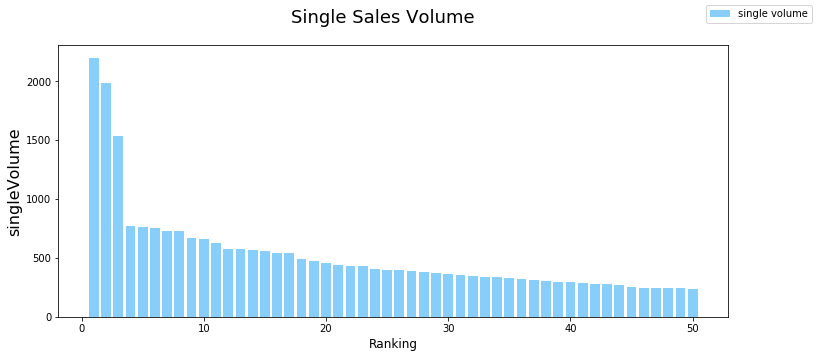

In [37]:
d = df_product.sort_values(by='sales', ascending=False).reset_index().drop('index', axis=1)['sales'][:50]
# d = df_vol['vol'][:50]
# total_vol = list(d.cumsum())[-1]
# d_percent = round(d.cumsum() / total_vol * 100, 3)

fig, ax1 = plt.subplots(figsize=(12,5))
# ax1.plot(d, label='single volume', color='lightskyblue')
ax1.bar(np.arange(len(d))+1, d, label='single volume', color='lightskyblue')
fig.suptitle('Single Sales Volume', fontsize=18)
ax1.set_xlabel('Ranking', fontsize=12)
ax1.set_ylabel('singleVolume', fontsize=16)

# ax2 = ax1.twinx()
# ax2.plot(d.cumsum(), label='accumulated volume', color = 'yellowgreen')
# ax2.set_ylabel('accumulatedVolume', fontsize=16)

fig.legend()

In [38]:
def graph(kind):
    mapping = {'f':'frequency', 
               'q':'quantity', 
               'a':'avg_quantity', 
               'p':'price', 
               's':'sales'}
    df = df_product.sort_values(by=mapping[kind], ascending=False).reset_index().drop('index', axis=1)
    d = df[mapping[kind]]
    total_vol = list(d.cumsum())[-1]
    d_percent = round(d.cumsum() / total_vol * 100, 3)

    fig, ax1 = plt.subplots(figsize=(12,5))
    ax1.plot(d, label='single volume', color='lightskyblue')
    fig.suptitle('Single / Accumulated Sales Volume', fontsize=18)
    ax1.set_xlabel('Ranking', fontsize=12)
    ax1.set_ylabel('singleVolume', fontsize=16)

    ax2 = ax1.twinx()
    ax2.plot(d.cumsum(), label='accumulated volume', color = 'yellowgreen')
    ax2.set_ylabel('accumulatedVolume', fontsize=16)

    fig.legend()

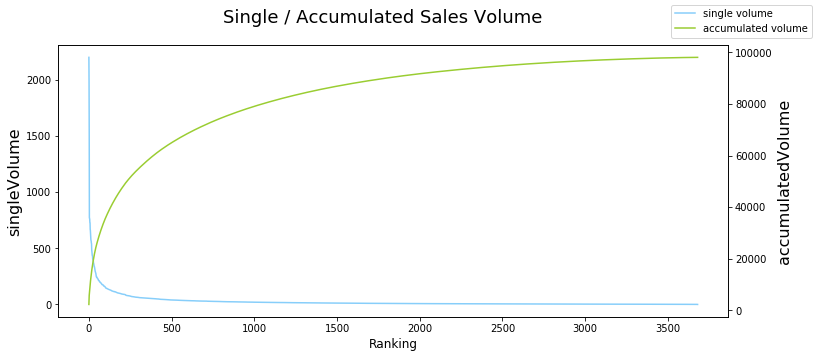

In [39]:
graph('s')

# Tail Products

In [40]:
df_product['quantity'].mean()

6.7799511002444985

In [41]:
df_tail = df_product[df_product['quantity']<=1]

In [42]:
len(df_tail)

1026

In [43]:
def tail_ratio(kind):
    sum_ratio = round(df_tail[kind].sum() / df_product[kind].sum() * 100, 3)
    avg_ratio = round(df_tail[kind].mean() / df_product[kind].mean() * 100, 3)
    return sum_ratio, avg_ratio

In [44]:
for i in ['frequency', 'quantity', 'avg_quantity', 'price', 'sales']:
    print(tail_ratio(i))

(5.752, 20.637)
(4.103, 14.721)
(21.196, 76.044)
(28.255, 101.37)
(4.853, 17.412)


# Purchase Time

In [45]:
df_receipt.groupby('Hour')['total'].sum()

Hour
06       43.35
07     2687.20
08     8432.95
09    10018.50
10    10947.90
11    11103.15
12     8188.15
13     7712.20
14     5902.35
15     4992.20
16     4307.75
17     4716.95
18     5442.15
19     4920.30
20     5605.05
21     1830.00
Name: total, dtype: float64

<BarContainer object of 16 artists>

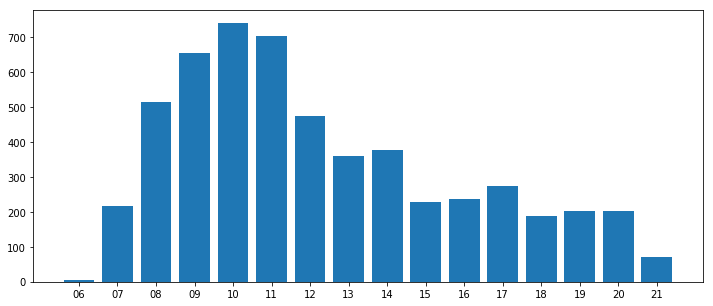

In [46]:
d = df_receipt.groupby('Hour')['total'].size()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(d.index, d)

Text(0,0.5,'Sales')

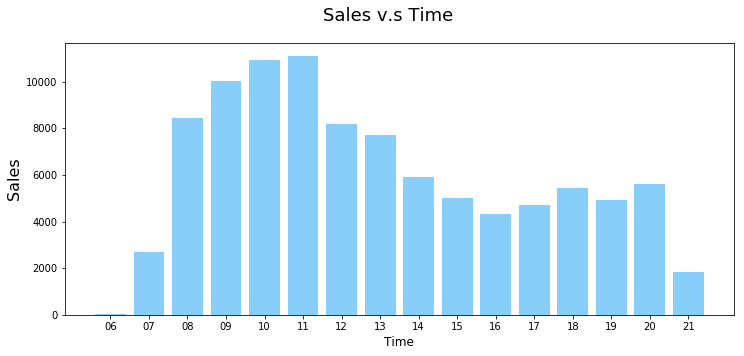

In [47]:
d = df_receipt.groupby('Hour')['total'].sum()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(d.index, d, label='sales', color='lightskyblue')

fig.suptitle('Sales v.s Time', fontsize=18)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Sales', fontsize=16)

<BarContainer object of 16 artists>

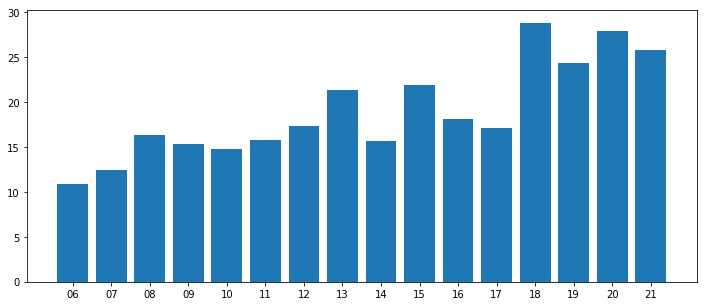

In [48]:
d = df_receipt.groupby('Hour')['total'].mean()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(d.index, d)

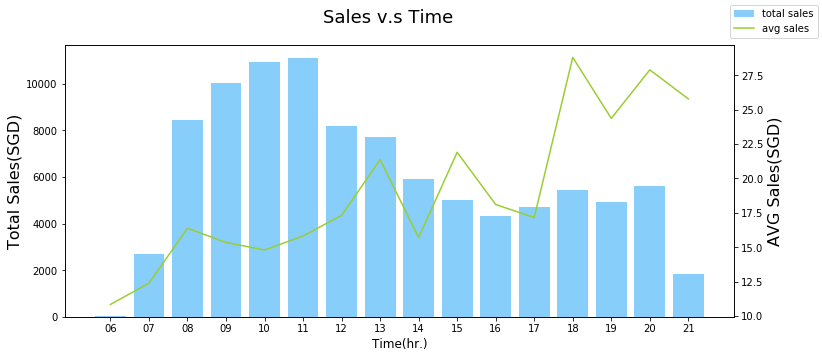

In [49]:
d = df_receipt.groupby('Hour')['total']
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(d.sum().index, d.sum(), label='total sales', color='lightskyblue')

fig.suptitle('Sales v.s Time', fontsize=18)
ax1.set_xlabel('Time(hr.)', fontsize=12)
ax1.set_ylabel('Total Sales(SGD)', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(d.mean(), label='avg sales', color = 'yellowgreen')
ax2.set_ylabel('AVG Sales(SGD)', fontsize=16)

fig.legend()

<BarContainer object of 16 artists>

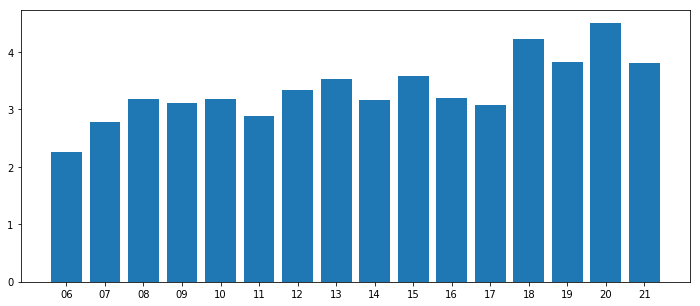

In [50]:
d = df_receipt.groupby('Hour')['items'].mean()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(d.index, d)

# Payment Method

In [51]:
def detail(kind):
    g = df_receipt.groupby(['payment_method'])[kind]
    c = g.size().reset_index().rename(columns={kind: 'count'})
    s = g.sum().reset_index().rename(columns={kind: 'sum'})
    m = g.mean().reset_index().rename(columns={kind: 'mean'})
    res = pd.merge(pd.merge(c, s), m)
    return res

In [52]:
payment = detail('total')

In [53]:
payment

,payment_method,count,sum,mean
0,Cash,4402,67103.45,15.243855
1,Nets,1042,29746.70,28.547697


In [54]:
detail('items')

,payment_method,count,sum,mean
0,Cash,4402,13557,3.079736
1,Nets,1042,4313,4.139155


In [55]:
payment_detail = pd.DataFrame(df_receipt.groupby(['payment_method', 'Hour'])['total'].size()).reset_index()
c = payment_detail[payment_detail['payment_method']=='Cash'].set_index('Hour')
n = payment_detail[payment_detail['payment_method']=='Nets'].set_index('Hour')
pd.merge(payment_detail[payment_detail['payment_method']=='Cash'],payment_detail[payment_detail['payment_method']=='Nets'], on = 'Hour' )

,payment_method_x,Hour,total_x,payment_method_y,total_y
0,Cash,07,192,Nets,25
1,Cash,08,463,Nets,52
2,Cash,09,605,Nets,48
3,Cash,10,670,Nets,70
4,Cash,11,614,Nets,88
5,Cash,12,376,Nets,97
6,Cash,13,285,Nets,76
7,Cash,14,303,Nets,73
8,Cash,15,169,Nets,59
9,Cash,16,187,Nets,50


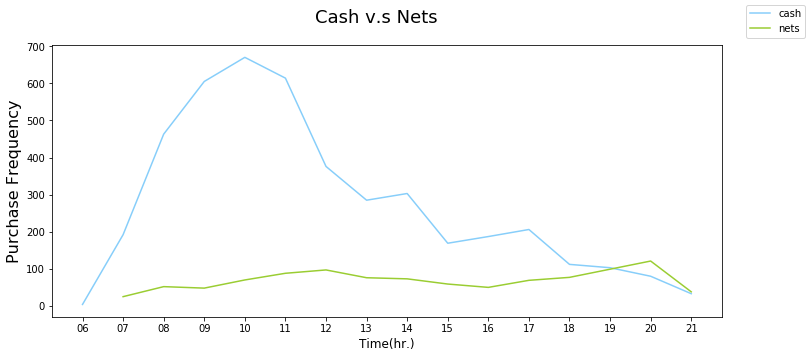

In [56]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(c['total'], label='cash', color='lightskyblue')
ax1.plot(n['total'], label='nets', color='yellowgreen')

fig.suptitle('Cash v.s Nets', fontsize=18)
ax1.set_xlabel('Time(hr.)', fontsize=12)
ax1.set_ylabel('Purchase Frequency', fontsize=16)

fig.legend()

# Different Purchasing Habit

In [57]:
df_c = df_join[df_join['payment_method'] == 'Cash']
df_n = df_join[df_join['payment_method'] == 'Nets']

In [58]:
c = FindKeyWord(df_c)
c_list = list(map(lambda x:x[0], c.filter_count()[:30]))
n = FindKeyWord(df_n)
n_list = list(map(lambda x:x[0], n.filter_count()[:30]))

In [59]:
print(c_list)

['MILK', 'CHICKEN', 'EGGS', 'WHITE', 'RICE', 'FRESH', 'BREAD', 'SAUCE', 'CREAM', 'POKKA', 'GARDENIA', 'LEMON', 'MISC', 'SUGAR', 'MAGGI', 'SUNSHINE', 'POWDER', 'MILO', 'GREEN', 'SUPER', 'ENRICHED', 'ORIGINAL', 'BUTTER', 'FLOUR', 'PLAIN', 'CURRY', 'NESCAFE', 'CRACKERS', 'CHILLI', 'FEAST']


In [60]:
print(list(set(n_list).difference(set(c_list))))

['TUNA', 'AYAM', 'WING', 'FANCY', 'FISH', 'ATAS']


In [61]:
print(n_list)

['CHICKEN', 'MILK', 'TUNA', 'FRESH', 'WHITE', 'EGGS', 'CREAM', 'RICE', 'BREAD', 'SUGAR', 'FEAST', 'FANCY', 'MAGGI', 'POKKA', 'ATAS', 'SUNSHINE', 'LEMON', 'MILO', 'CURRY', 'ORIGINAL', 'GARDENIA', 'POWDER', 'SAUCE', 'WING', 'SUPER', 'PLAIN', 'ENRICHED', 'BUTTER', 'FISH', 'AYAM']


In [62]:
list(set(c_list).difference(set(n_list)))

['MISC', 'CRACKERS', 'FLOUR', 'NESCAFE', 'GREEN', 'CHILLI']

In [63]:
def dif(num):
    c = FindKeyWord(df_c)
    c_list = list(map(lambda x:x[0], c.filter_count()[:num]))
    n = FindKeyWord(df_n)
    n_list = list(map(lambda x:x[0], n.filter_count()[:num]))
    return list(set(n_list).difference(set(c_list)))

In [64]:
for i in range(0,100,15):
    print(i, dif(i))

0 []
15 ['FANCY', 'FEAST', 'TUNA', 'ATAS']
30 ['TUNA', 'AYAM', 'WING', 'FANCY', 'FISH', 'ATAS']
45 ['CHEESE', 'AATAS', 'CRISPY', 'WINGS', 'CEREAL', 'GOLD', 'FISH', 'ATAS', 'NESTLE', 'DRYPERS']
60 ['CHEESE', 'DRINK', 'AATAS', 'SWEET', 'WINGS', 'DUGRO', 'ROASTED', 'CEREAL', 'GOLD', 'BREEZE', 'CHOCOLATE', 'ATAS', 'NESTLE', 'MEIJI', 'DRYPERS']
75 ['AATAS', 'SPICY', 'SWEET', 'WINGS', 'DUGRO', 'ROASTED', 'STRAWBERRY', 'PURE', 'CEREAL', 'PACK', 'OCEAN', 'NUGGETS', 'CERELAC', 'STAGE', 'STEP', 'RAMEN', 'BREEZE', 'ATAS', 'NESTLE', 'DRYPERS']
90 ['STICK', 'BREEZE', 'ATAS', 'HALAL', 'DRYPERS', 'AATAS', 'CERELAC', 'APPLE', 'STRAWBERRY', 'COLGATE', 'JUICE', 'DUGRO', 'STAGE', 'SALMON', 'PURE', 'SWEET', 'WINGS', 'CEREAL', 'PACK', 'OCEAN', 'STEP', 'RAMEN', 'DETTOL', 'NESTLE']


# Buy this also buys

In [65]:
# select a.* from df a 
# join (select 'receipt_id' from df_join where 'itemName' like x) b 
# on a.'receipt_id' = b.'receipt_id'
def dfwithspecial(x, df):
    return pd.merge(df, pd.DataFrame(df_join[df_join['itemName'].str.contains(x)]['receipt_id']).drop_duplicates('receipt_id'))

In [66]:
dfwithspecial('SUGER', df_join).head()

,itemName,price,quantity,subtotal,total,receipt_id,date,time,Hour,weekday,timestamp,payment_method
0,GARNIER MEN FACIAL FOAM ICY DUOFOAM 100G,3.0,1,3.0,24.5,T3-734262,2018-09-02,08:06:14,08,Sun,2018-09-02 08:06:14,Cash
1,SUNSHINE SOFT WHITE BREAD 400G,2.0,1,2.0,24.5,T3-734262,2018-09-02,08:06:14,08,Sun,2018-09-02 08:06:14,Cash
2,KNIFE BLENDED OIL 2L,6.7,1,6.7,24.5,T3-734262,2018-09-02,08:06:14,08,Sun,2018-09-02 08:06:14,Cash
3,OT 3IN1 WHITE COFFEE LESS SUGER 15'SX35G,5.8,1,5.8,24.5,T3-734262,2018-09-02,08:06:14,08,Sun,2018-09-02 08:06:14,Cash
4,OT 3IN1 NAT CANE SUGAR W/COFFEE15'SX36G,5.8,1,5.8,24.5,T3-734262,2018-09-02,08:06:14,08,Sun,2018-09-02 08:06:14,Cash


In [67]:
dfwithspecial('SUGER', df_receipt).head()

,receipt_id,date,time,Hour,weekday,items,timestamp,total,payment_method
0,T3-734262,2018-09-02,08:06:14,08,Sun,6,2018-09-02 08:06:14,24.5,Cash
1,T3-737045,2018-09-05,08:23:03,08,Wed,3,2018-09-05 08:23:03,15.8,Cash
2,T3-742241,2018-09-10,13:35:58,13,Mon,4,2018-09-10 13:35:58,63.8,Nets
3,T3-743126,2018-09-11,12:40:12,12,Tue,3,2018-09-11 12:40:12,11.1,Cash
4,T3-743483,2018-09-11,18:45:59,18,Tue,6,2018-09-11 18:45:59,33.1,Cash


In [68]:
total = FindKeyWord(df_join)
potential_key = list(map(lambda x:x[0], total.filter_count()[:100]))
print(potential_key)

['MILK', 'CHICKEN', 'EGGS', 'WHITE', 'RICE', 'FRESH', 'BREAD', 'CREAM', 'POKKA', 'SAUCE', 'GARDENIA', 'LEMON', 'SUGAR', 'MAGGI', 'SUNSHINE', 'POWDER', 'MILO', 'TUNA', 'SUPER', 'MISC', 'GREEN', 'ORIGINAL', 'ENRICHED', 'BUTTER', 'FEAST', 'CURRY', 'FANCY', 'PLAIN', 'FLOUR', 'NESCAFE', 'WING', 'CRACKERS', 'AYAM', 'REFILL', 'CHILLI', 'SOFT', 'ROLL', 'COFFEE', 'FINE', 'CRISPY', 'LIQUID', 'SWEETENED', 'JASMINE', 'FISH', 'FRIED', 'SOYA', 'COCONUT', 'BLEACH', 'CREAMER', 'ATAS', 'GOLDEN', 'EXTRA', 'COKE', 'WHOLEMEAL', 'COLOUR', 'GOLD', 'CLASSIC', 'CHEESE', 'DRINK', 'DETERGENT', 'VERMICELLI', 'FRISKIES', 'WINGS', 'TOMATO', 'KNORR', 'CHOCOLATE', 'MEIJI', 'SALT', 'ROASTED', 'CORN', 'HONEY', 'ASIAN', 'STORY', 'SPICY', 'NESTLE', 'CEREAL', 'KITCHEN', 'NUGGETS', 'SARDINES', 'SWEET', 'LIPTON', 'BREEZE', 'LIME', 'YELLOW', 'GORENG', 'JULIE', 'JUICE', 'BEAUTEX', 'INSTANT', 'FRUIT', 'TISSUE', 'PREMIUM', 'LABEL', 'STICK', 'SALTED', 'MYOJO', 'PACK', 'PLUS', 'JUMBO', 'MUSHROOM']


In [69]:
key = ['MILK', 'CHICKEN', 'EGGS', 'RICE', 'BREAD', 'CREAM', 'MAGGI', 'SAUCE', 'SUGAR', 
       'CURRY', 'TUNA', 'POKKA']

In [70]:
def alsobuys(word, end_num=30):
    a = FindKeyWord(dfwithspecial(word, df_join))
    also = a.filter_count()[1:end_num]
    res = [word,also]
    return res

In [71]:
similar = []
for i in key:
    similar.append(alsobuys(i, end_num=6))
pd.DataFrame(dict(similar))

,MILK,CHICKEN,EGGS,RICE,BREAD,CREAM,MAGGI,SAUCE,SUGAR,CURRY,TUNA,POKKA
0,"[FRESH, 265]","[TUNA, 180]","[MILK, 153]","[CHICKEN, 118]","[WHITE, 234]","[MILK, 314]","[CURRY, 155]","[MAGGI, 126]","[MILK, 133]","[MAGGI, 191]","[FANCY, 159]","[GREEN, 182]"
1,"[CREAM, 230]","[FEAST, 178]","[FRESH, 153]","[MILK, 113]","[GARDENIA, 220]","[CREAMER, 143]","[CHICKEN, 120]","[CHILLI, 116]","[CHICKEN, 87]","[CHICKEN, 96]","[FEAST, 156]","[JASMINE, 127]"
2,"[PLAIN, 142]","[FANCY, 170]","[CHICKEN, 152]","[SAUCE, 92]","[SUNSHINE, 169]","[CHICKEN, 135]","[SAUCE, 109]","[CHICKEN, 100]","[FINE, 79]","[POWDER, 87]","[CHICKEN, 142]","[CHICKEN, 79]"
3,"[CHICKEN, 135]","[MILK, 132]","[BREAD, 95]","[VERMICELLI, 87]","[ENRICHED, 157]","[SWEETENED, 126]","[MILK, 85]","[MILK, 82]","[SUNSHINE, 72]","[MILK, 72]","[ATAS, 131]","[LEMON, 77]"
4,"[MILO, 130]","[MAGGI, 131]","[WHITE, 94]","[EGGS, 78]","[MILK, 129]","[CRACKERS, 112]","[CHILLI, 79]","[SOYA, 79]","[CREAM, 68]","[SAUCE, 55]","[AATAS, 81]","[MILK, 73]"


# Receipt

In [72]:
df_receipt.head()

,receipt_id,date,time,Hour,weekday,items,timestamp,total,payment_method
0,T3-733343,2018-09-01,07:34:45,07,Sat,2,2018-09-01 07:34:45,15.80,Cash
1,T3-733346,2018-09-01,07:38:54,07,Sat,6,2018-09-01 07:38:54,70.45,Cash
2,T3-733350,2018-09-01,07:43:41,07,Sat,1,2018-09-01 07:43:41,1.40,Cash
3,T3-733354,2018-09-01,07:46:37,07,Sat,4,2018-09-01 07:46:37,9.20,Cash
4,T3-733355,2018-09-01,07:47:18,07,Sat,2,2018-09-01 07:47:18,61.90,Cash


In [73]:
items_sta = df_receipt.groupby('items').size().reset_index().rename({0:'num'}, axis=1)
round(items_sta[items_sta['items']<=5]['num'].sum() / items_sta['num'].sum() * 100, 3)

86.924

Text(0,0.5,'Num.')

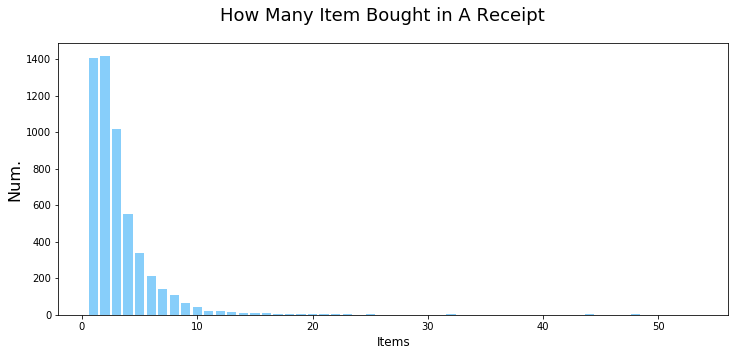

In [74]:
d = df_receipt.groupby('items').size()
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(d.index, d, label='items', color='lightskyblue')

fig.suptitle('How Many Item Bought in A Receipt', fontsize=18)
ax1.set_xlabel('Items', fontsize=12)
ax1.set_ylabel('Num.', fontsize=16)

In [75]:
g = df_receipt.groupby(['payment_method'])['items']
i_count = g.size().reset_index().rename(columns={'items': 'count'})
i_sum = g.sum().reset_index().rename(columns={'items': 'sum'})
i_mean = g.mean().reset_index().rename(columns={'items': 'mean'})
items = pd.merge(pd.merge(i_count, i_sum), i_mean)

In [76]:
items

,payment_method,count,sum,mean
0,Cash,4402,13557,3.079736
1,Nets,1042,4313,4.139155


In [77]:
sku = FindKeyWord(df_sku)
for i in range(1,15):
    top_list = total.filter_count(min_purchase=i)
    print(i, len(top_list))

1 2156
2 1775
3 1513
4 1326
5 1194
6 1084
7 1000
8 915
9 872
10 822
11 758
12 723
13 681
14 649


In [78]:
def _ratio(df):
    payment_method = df.groupby('payment_method').size()
    try:
        n = payment_method['Nets']
    except KeyError:
        n = 0
    try:
        c = payment_method['Cash']
    except KeyError:
        c = 0
    try:
        return round(n / (c+n) * 100, 3)
    except ZeroDivisionError:
        return None
def keywordinformation(key):
    df_key = dfwithspecial(key, df_receipt)
    m_items = df_key['items'].median()
    m_total = df_key['total'].median()
    nets_ratio = _ratio(df_key)
    return m_items, m_total, nets_ratio

In [79]:
keywordinformation('')

(2.0, 11.4, 19.14)

In [80]:
sku_30 = sku.filter_count(min_purchase=30)
check = list(map(lambda x:x[0], sku_30))
len(check)

354

In [81]:
for i in sku_30:
    key = i[0]
#     print(key)
    i.extend(keywordinformation(key))

In [82]:
sorted(sku_30, key=lambda d: d[3], reverse=True)

[['STAGE', 48, 2.0, 74.6, 60.417],
 ['ENFAGROW', 33, 2.0, 72.0, 63.636],
 ['STEP', 56, 3.0, 53.8, 53.846],
 ['CARLSBERG', 30, 2.0, 44.8, 24.0],
 ['VANILLA', 58, 3.5, 35.25, 34.483],
 ['DUGRO', 60, 3.0, 35.0, 52.727],
 ['HABHAL', 71, 8.5, 33.95, 33.333],
 ['TAFFY', 44, 7.5, 32.775, 36.364],
 ['XIANGMI', 43, 3.0, 30.9, 23.81],
 ['LIFEBUOY', 50, 5.0, 29.7, 26.667],
 ['HAZELNUT', 33, 6.0, 29.1, 51.111],
 ['TALL', 46, 7.0, 28.450000000000003, 35.185],
 ['GOLD', 130, 3.0, 27.5, 34.05],
 ['TEMPTATIONS', 33, 7.5, 27.45, 30.0],
 ['PANTENE', 39, 6.0, 27.2, 27.273],
 ['ROYAL', 33, 4.0, 26.825, 17.647],
 ['ONWARDS', 79, 5.0, 26.8, 25.882],
 ['SHOWER', 33, 7.0, 26.65, 35.484],
 ['COARSE', 54, 7.0, 26.55, 28.302],
 ['FALL', 31, 6.5, 26.299999999999997, 33.333],
 ['ACTIVGO', 55, 5.0, 25.9, 32.727],
 ['BABAS', 59, 8.0, 25.75, 30.556],
 ['MACKEREL', 37, 8.0, 25.575, 35.294],
 ['DETTOL', 84, 5.0, 25.2, 30.667],
 ['LIQUID', 166, 6.0, 25.05, 27.517],
 ['MAMY', 59, 3.0, 25.0, 30.189],
 ['PURPLE', 52, 4.0, 

In [83]:
df_key = pd.DataFrame(sku_30, columns=['keyword', 'total_purchase', 'm_items', 'm_total', 'nets_ratio'])

In [84]:
df_key.head()

,keyword,total_purchase,m_items,m_total,nets_ratio
0,MILK,1004,4.0,13.725,22.600
1,CHICKEN,920,4.0,18.200,28.811
2,EGGS,721,3.0,12.400,17.564
3,WHITE,582,4.0,13.900,22.552
4,RICE,512,4.0,18.300,17.834


In [85]:
df_key.sort_values(by='nets_ratio', ascending=False)[:10][['keyword', 'nets_ratio']]

,keyword,nets_ratio
331,ENFAGROW,63.636
242,STAGE,60.417
125,AATAS,56.250
207,STEP,53.846
185,DUGRO,52.727
326,HAZELNUT,51.111
103,DRYPERS,49.412
304,KRUNCH,48.485
204,CERELAC,47.826
49,ATAS,45.205


In [86]:
def time_items(h, num):
    df_x = pd.merge(df_sku, pd.DataFrame(df_receipt[df_receipt['Hour']==h]['receipt_id']))
    return list(map(lambda x:x[0], FindKeyWord(df_x).filter_count()[:num]))

In [96]:
for i in list(df_receipt['Hour'].drop_duplicates()):
    print(i, time_items(i, 7))

07 ['EGGS', 'MILK', 'CHICKEN', 'FRESH', 'POWDER', 'LEMON', 'WHITE']
08 ['MILK', 'EGGS', 'CHICKEN', 'WHITE', 'RICE', 'SAUCE', 'FRESH']
09 ['MILK', 'CHICKEN', 'EGGS', 'RICE', 'WHITE', 'SAUCE', 'BREAD']
10 ['CHICKEN', 'EGGS', 'MILK', 'WHITE', 'RICE', 'FRESH', 'MISC']
11 ['MILK', 'CHICKEN', 'EGGS', 'FRESH', 'WHITE', 'BREAD', 'CREAM']
12 ['MILK', 'CHICKEN', 'EGGS', 'WHITE', 'BREAD', 'RICE', 'CREAM']
13 ['CHICKEN', 'MILK', 'EGGS', 'POKKA', 'BREAD', 'WHITE', 'FANCY']
14 ['CHICKEN', 'MILK', 'EGGS', 'WHITE', 'RICE', 'MISC', 'POKKA']
15 ['CHICKEN', 'MILK', 'MISC', 'EGGS', 'ORIGINAL', 'RICE', 'CREAM']
16 ['CHICKEN', 'MILK', 'RICE', 'POKKA', 'WHITE', 'EGGS', 'MAGGI']
17 ['MILK', 'CHICKEN', 'WHITE', 'POKKA', 'CREAM', 'FRESH', 'EGGS']
18 ['MILK', 'CHICKEN', 'TUNA', 'EGGS', 'WHITE', 'RICE', 'FRESH']
19 ['CHICKEN', 'MILK', 'EGGS', 'WHITE', 'FEAST', 'FRESH', 'SUPER']
20 ['MILK', 'CHICKEN', 'FRESH', 'WHITE', 'POWDER', 'BREAD', 'EGGS']
21 ['MILK', 'CHICKEN', 'CREAM', 'FRESH', 'RICE', 'SUGAR', 'ROLL']
06 

Text(0,0.5,'Sales Amu.')

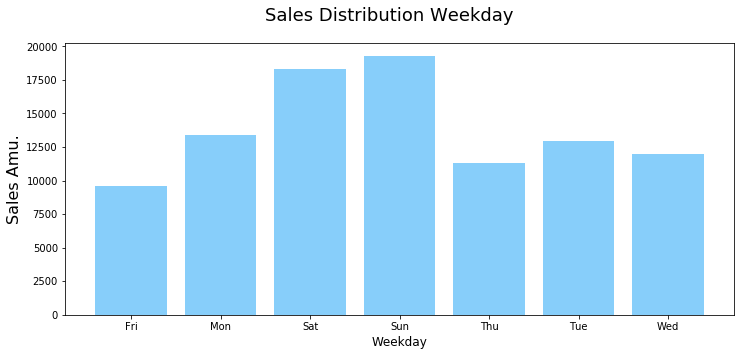

In [134]:
d = df_receipt.groupby('weekday').sum()['total']
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.bar(d.index, d, label='sales', color='lightskyblue')

fig.suptitle('Sales Distribution Weekday', fontsize=18)
ax1.set_xlabel('Weekday', fontsize=12)
ax1.set_ylabel('Sales Amu.', fontsize=16)